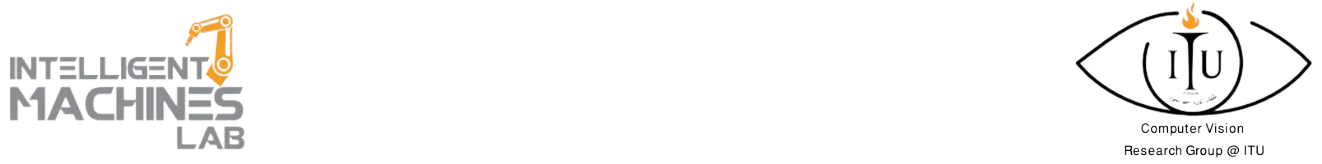

## Generative AI & LLM Fall 2024
## Assignment 2: Implementing a VAE using CNN and pytorch

In this assignment, you will implement a VAE using CNN and pytorch. You will use the MNIST dataset for this assignment.

**You will need to implement the following:**

1. The VAE Model
2. Kaiming Initialization also known as He Initialization (https://paperswithcode.com/method/he-initialization)
3. The VAE loss function
4. The forward pass
5. The training loop
6. The evaluation loop
7. The sampling loop
8. Visualize the latent space


**Guidelines:**

1. Use this notebook as a template to implement the VAE model.
2. Try your best to avoid using ChatGPT or any other LLM to complete this assignment.
3. If you get stuck, please reach out at `manzoor.rohan97@gmail.com`
4. Ensure proper formatting of the code.
5. While you will be implementing the assignment on Colab, you are also required to upload the project to github and share the link with us.


**The assignment will be evaluated based on the following criteria:**

| Criteria                | Marks |
|-------------------------|-------|
| 1. VAE model            | 2.5   |
| 2. Training Loop        | 2.5   |
| 3. Correct Sampling     | 2.0   |
| 4. Viva                 | 3.0   |
| Total                   | 10.0  |


Name: Ayesha Zafar

Reg No: MSDS23011

Github Link:  https://github.com/Ayesha-Zafar1/CNN-VAE-

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import numpy as np

# Model Definition

In [20]:
def weights_init(m):
    # TODO: Use He Initialization and use this function to initialize the weights of the model

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [22]:

class CNN_VAE(nn.Module):
    def __init__(self, input_channels=1, h_dims=[32, 64], latent_dims=2):
        """
        Initializes the CNN_VAE model.

        Args:
            input_channels (int): Number of input channels (e.g., 1 for grayscale images).
            h_dims (list): A list defining the number of output channels for each convolutional layer in the encoder.
            latent_dims (int): Dimensionality of the latent space.
        """
        super(CNN_VAE, self).__init__()

        # TODO: Initialize the encoder Layers
        # You encoder will have 2 convolutional layers, a fixed kernel size of 3, stride of 2, padding of 1
        # The output of the encoder will be flattened to a single vector


        # TODO: Initialize the FC layers to output the mean and log variance


        # TODO: Initialize the decoder layers
        # The decoder will have 2 transposed convolutional layers, a fixed kernel size of 3, stride of 2, padding of 1
        # The output of the decoder will be a tensor of the same size as the input


        # TODO: Apply weight initialization using the weights_init function

        self.h_dims = h_dims


        self.conv1 = nn.Conv2d(input_channels, h_dims[0], kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(h_dims[0], h_dims[1], kernel_size=3, stride=2, padding=1)


        self.fc_mu = nn.Linear(h_dims[1] * 7 * 7, latent_dims)
        self.fc_logvar = nn.Linear(h_dims[1] * 7 * 7, latent_dims)


        self.fc_decode = nn.Linear(latent_dims, h_dims[1] * 7 * 7)


        self.conv3 = nn.ConvTranspose2d(h_dims[1], h_dims[0], kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv4 = nn.ConvTranspose2d(h_dims[0], input_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from the latent space.

        Args:
            mu (torch.Tensor): Mean of the latent distribution.
            logvar (torch.Tensor): Log variance of the latent distribution.

        Returns:
            torch.Tensor: Sampled latent variable from the distribution defined by mu and logvar.
        """
        # TODO: Implement the reparametrization trick. Notice the input argument is logvar and not sigma. Can you guess why?

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        return eps * std + mu

    def encode(self, x):
        """
        Encodes the input data into the latent space representation.

        Args:
            x (torch.Tensor): Input data (e.g., images) to be encoded.

        Returns:
            tuple: A tuple containing:
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        # TODO: Implement the encoding process

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        return mu, logvar

    def decode(self, z):
        """
        Decodes the latent representation back to the original data space.

        Args:
            z (torch.Tensor): Latent representation to be decoded.

        Returns:
            torch.Tensor: Reconstructed data from the latent representation.
        """
        # TODO: Implement the decoding process

        x = F.relu(self.fc_decode(z))
        x = x.view(x.size(0), self.h_dims[1], 7, 7)
        x = F.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        return x

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input data (e.g., images) for reconstruction.

        Returns:
            tuple: A tuple containing:
                - x_reconstructed (torch.Tensor): Reconstructed input data.
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        # TODO: Implement the forward pass

        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar


# Usage
INPUT_CHANNELS = 1
INPUT_SIZE = 28
model = CNN_VAE(input_channels=INPUT_CHANNELS)
output, mu, logvar = model.forward(torch.randn((1, INPUT_CHANNELS, INPUT_SIZE, INPUT_SIZE)))
print(output.shape)

torch.Size([1, 1, 28, 28])


# Dataset Loading

In [46]:
# Hyper-parameters
# you can change these to see how the model performs
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
INPUT_DIMS = 1
HID_DIMS = [32, 64]
Z_DIMS = 20
NUM_EPOCHS = 50
LR = 1e-4
BATCH_SIZE = 32
VAL_AFTER = 800

In [47]:
# Loading dataset

# TODO: Load the MNIST dataset and prepare the dataloaders.
# You can use the torchvision.datasets.MNIST and torch.utils.data.DataLoader to load the dataset.
# You will need separate daataloader for train and test set

train_dataset = torchvision.datasets.MNIST(root='./data',train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor(),download = True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=BATCH_SIZE, shuffle=False)


for images, labels in train_loader:
    print(f'Batch of images: {images.shape}')
    print(f'Batch of labels: {labels.shape}')
    break

Batch of images: torch.Size([32, 1, 28, 28])
Batch of labels: torch.Size([32])


In [44]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

def plot_image(img, nrow=10):
    plt.figure(figsize=(10, 6))
    plt.imshow(make_grid(img, nrow=nrow).permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

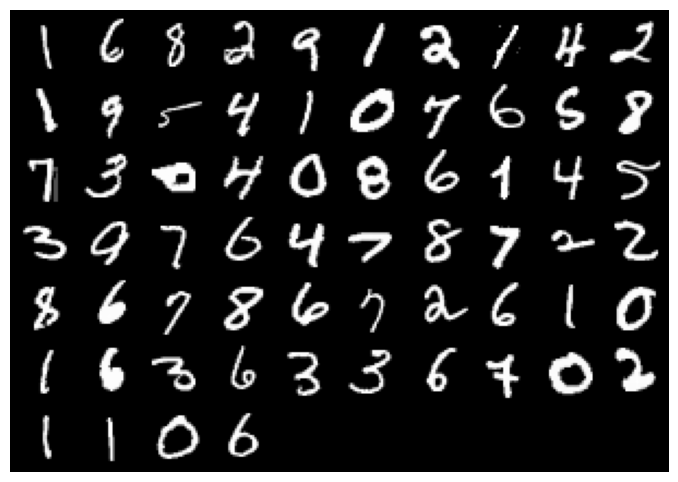

In [45]:
# TODO: Use the plot_image function to plot the images

# Get a batch of training images
images, labels = next(iter(train_loader))

plot_image(images)

# Training Loop

In [48]:
# Define VAE loss
def vae_loss(reconstructed_x, x, mu, logvar):
    # TODO: Implement the VAE loss function

    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [49]:
from tqdm import tqdm

# Instructions:
# 1. Initialize the model and the optimizer. You will be using Adam optimizer
# 2. Implement a training loop that iterates over the training data, performs forward and backward passes, and updates the model parameters.
# 3. Implement a validation loop that evaluates the model on the validation data.
# 4. Implement a progress bar to visualize the training progress.
# 5. Store your training and validation losses in train_losses and eval_losses respectively.

model = CNN_VAE(INPUT_DIMS, HID_DIMS, Z_DIMS).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_losses = []
eval_losses = []
NUM_EPOCHS = 50

# Training Loop
for epoch in range(NUM_EPOCHS):

    model.train()
    running_train_loss = 0.0


    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))

    for batch_idx, (data, _) in progress_bar:
        data = data.to(DEVICE)

        # Forward pass
        optimizer.zero_grad()
        reconstructed, mu, logvar = model(data)

        loss = vae_loss(reconstructed, data, mu, logvar)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # Updating the progress bar
        progress_bar.set_description(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Training Loss: {avg_train_loss:.4f}')

    # Validation Loop
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(DEVICE)

            reconstructed, mu, logvar = model(data)

            loss = vae_loss(reconstructed, data, mu, logvar)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader)
    eval_losses.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Validation Loss: {avg_val_loss:.4f}')

Epoch [1/50], Loss: 4824.8047: 100%|██████████| 1875/1875 [01:09<00:00, 26.94it/s]


Epoch [1/50], Training Loss: 6552.9366
Epoch [1/50], Validation Loss: 4604.0560


Epoch [2/50], Loss: 4089.0388: 100%|██████████| 1875/1875 [01:10<00:00, 26.55it/s]


Epoch [2/50], Training Loss: 4228.2197
Epoch [2/50], Validation Loss: 3939.2307


Epoch [3/50], Loss: 3647.1536: 100%|██████████| 1875/1875 [01:09<00:00, 27.01it/s]


Epoch [3/50], Training Loss: 3879.8158
Epoch [3/50], Validation Loss: 3755.9467


Epoch [4/50], Loss: 3764.0649: 100%|██████████| 1875/1875 [01:08<00:00, 27.26it/s]


Epoch [4/50], Training Loss: 3740.7994
Epoch [4/50], Validation Loss: 3660.2966


Epoch [5/50], Loss: 3749.8147: 100%|██████████| 1875/1875 [01:08<00:00, 27.23it/s]


Epoch [5/50], Training Loss: 3656.4171
Epoch [5/50], Validation Loss: 3595.1612


Epoch [6/50], Loss: 3553.9883: 100%|██████████| 1875/1875 [01:09<00:00, 27.13it/s]


Epoch [6/50], Training Loss: 3596.9092
Epoch [6/50], Validation Loss: 3536.1992


Epoch [7/50], Loss: 3482.6150: 100%|██████████| 1875/1875 [01:12<00:00, 25.70it/s]


Epoch [7/50], Training Loss: 3553.6251
Epoch [7/50], Validation Loss: 3504.9625


Epoch [8/50], Loss: 3417.5732: 100%|██████████| 1875/1875 [01:09<00:00, 27.14it/s]


Epoch [8/50], Training Loss: 3519.8055
Epoch [8/50], Validation Loss: 3475.7825


Epoch [9/50], Loss: 3495.6875: 100%|██████████| 1875/1875 [01:10<00:00, 26.64it/s]


Epoch [9/50], Training Loss: 3493.5632
Epoch [9/50], Validation Loss: 3461.7318


Epoch [10/50], Loss: 3260.2461: 100%|██████████| 1875/1875 [01:09<00:00, 27.01it/s]


Epoch [10/50], Training Loss: 3471.5275
Epoch [10/50], Validation Loss: 3434.1367


Epoch [11/50], Loss: 3347.9509: 100%|██████████| 1875/1875 [01:09<00:00, 26.85it/s]


Epoch [11/50], Training Loss: 3452.1681
Epoch [11/50], Validation Loss: 3419.0686


Epoch [12/50], Loss: 3617.4717: 100%|██████████| 1875/1875 [01:09<00:00, 26.80it/s]


Epoch [12/50], Training Loss: 3437.4050
Epoch [12/50], Validation Loss: 3413.0617


Epoch [13/50], Loss: 3481.8779: 100%|██████████| 1875/1875 [01:09<00:00, 26.95it/s]


Epoch [13/50], Training Loss: 3423.2336
Epoch [13/50], Validation Loss: 3395.1570


Epoch [14/50], Loss: 3407.7637: 100%|██████████| 1875/1875 [01:10<00:00, 26.70it/s]


Epoch [14/50], Training Loss: 3411.9346
Epoch [14/50], Validation Loss: 3382.7308


Epoch [15/50], Loss: 3352.4668: 100%|██████████| 1875/1875 [01:09<00:00, 26.93it/s]


Epoch [15/50], Training Loss: 3402.0008
Epoch [15/50], Validation Loss: 3373.9847


Epoch [16/50], Loss: 3424.9775: 100%|██████████| 1875/1875 [01:09<00:00, 26.80it/s]


Epoch [16/50], Training Loss: 3391.8342
Epoch [16/50], Validation Loss: 3368.3616


Epoch [17/50], Loss: 3198.9775: 100%|██████████| 1875/1875 [01:10<00:00, 26.46it/s]


Epoch [17/50], Training Loss: 3384.1646
Epoch [17/50], Validation Loss: 3356.9293


Epoch [18/50], Loss: 3617.4658: 100%|██████████| 1875/1875 [01:09<00:00, 26.94it/s]


Epoch [18/50], Training Loss: 3376.9824
Epoch [18/50], Validation Loss: 3350.4564


Epoch [19/50], Loss: 3346.9827: 100%|██████████| 1875/1875 [01:10<00:00, 26.70it/s]


Epoch [19/50], Training Loss: 3368.9503
Epoch [19/50], Validation Loss: 3341.9193


Epoch [20/50], Loss: 3388.6365: 100%|██████████| 1875/1875 [01:09<00:00, 26.92it/s]


Epoch [20/50], Training Loss: 3362.9344
Epoch [20/50], Validation Loss: 3338.8893


Epoch [21/50], Loss: 3529.6755: 100%|██████████| 1875/1875 [01:10<00:00, 26.65it/s]


Epoch [21/50], Training Loss: 3354.5779
Epoch [21/50], Validation Loss: 3331.4051


Epoch [22/50], Loss: 3219.0442: 100%|██████████| 1875/1875 [01:11<00:00, 26.30it/s]


Epoch [22/50], Training Loss: 3350.1110
Epoch [22/50], Validation Loss: 3327.6118


Epoch [23/50], Loss: 3272.8367: 100%|██████████| 1875/1875 [01:10<00:00, 26.60it/s]


Epoch [23/50], Training Loss: 3345.1899
Epoch [23/50], Validation Loss: 3321.9716


Epoch [24/50], Loss: 3604.4465: 100%|██████████| 1875/1875 [01:10<00:00, 26.74it/s]


Epoch [24/50], Training Loss: 3338.5832
Epoch [24/50], Validation Loss: 3321.2345


Epoch [25/50], Loss: 3249.0417: 100%|██████████| 1875/1875 [01:11<00:00, 26.19it/s]


Epoch [25/50], Training Loss: 3335.0108
Epoch [25/50], Validation Loss: 3317.7219


Epoch [26/50], Loss: 3430.2620: 100%|██████████| 1875/1875 [01:10<00:00, 26.53it/s]


Epoch [26/50], Training Loss: 3329.2116
Epoch [26/50], Validation Loss: 3308.8573


Epoch [27/50], Loss: 3345.1855: 100%|██████████| 1875/1875 [01:10<00:00, 26.60it/s]


Epoch [27/50], Training Loss: 3326.0985
Epoch [27/50], Validation Loss: 3306.8396


Epoch [28/50], Loss: 3585.4351: 100%|██████████| 1875/1875 [01:11<00:00, 26.34it/s]


Epoch [28/50], Training Loss: 3320.2502
Epoch [28/50], Validation Loss: 3306.2330


Epoch [29/50], Loss: 3210.0022: 100%|██████████| 1875/1875 [01:10<00:00, 26.78it/s]


Epoch [29/50], Training Loss: 3316.1046
Epoch [29/50], Validation Loss: 3301.8833


Epoch [30/50], Loss: 3342.3848: 100%|██████████| 1875/1875 [01:09<00:00, 26.82it/s]


Epoch [30/50], Training Loss: 3312.9865
Epoch [30/50], Validation Loss: 3295.3654


Epoch [31/50], Loss: 3212.7642: 100%|██████████| 1875/1875 [01:11<00:00, 26.30it/s]


Epoch [31/50], Training Loss: 3309.6825
Epoch [31/50], Validation Loss: 3291.7325


Epoch [32/50], Loss: 3403.8438: 100%|██████████| 1875/1875 [01:10<00:00, 26.76it/s]


Epoch [32/50], Training Loss: 3306.0962
Epoch [32/50], Validation Loss: 3293.1592


Epoch [33/50], Loss: 3229.7192: 100%|██████████| 1875/1875 [01:10<00:00, 26.68it/s]


Epoch [33/50], Training Loss: 3302.6067
Epoch [33/50], Validation Loss: 3286.1570


Epoch [34/50], Loss: 3208.4263: 100%|██████████| 1875/1875 [01:11<00:00, 26.30it/s]


Epoch [34/50], Training Loss: 3298.9185
Epoch [34/50], Validation Loss: 3281.2355


Epoch [35/50], Loss: 3165.2595: 100%|██████████| 1875/1875 [01:10<00:00, 26.73it/s]


Epoch [35/50], Training Loss: 3296.3981
Epoch [35/50], Validation Loss: 3281.1165


Epoch [36/50], Loss: 3511.1045: 100%|██████████| 1875/1875 [01:10<00:00, 26.54it/s]


Epoch [36/50], Training Loss: 3293.0548
Epoch [36/50], Validation Loss: 3280.7830


Epoch [37/50], Loss: 3426.6694: 100%|██████████| 1875/1875 [01:11<00:00, 26.19it/s]


Epoch [37/50], Training Loss: 3289.9538
Epoch [37/50], Validation Loss: 3276.4401


Epoch [38/50], Loss: 3344.7656: 100%|██████████| 1875/1875 [01:10<00:00, 26.53it/s]


Epoch [38/50], Training Loss: 3288.1541
Epoch [38/50], Validation Loss: 3275.7975


Epoch [39/50], Loss: 3263.9802: 100%|██████████| 1875/1875 [01:11<00:00, 26.36it/s]


Epoch [39/50], Training Loss: 3284.1328
Epoch [39/50], Validation Loss: 3270.0987


Epoch [40/50], Loss: 3199.5906: 100%|██████████| 1875/1875 [01:11<00:00, 26.22it/s]


Epoch [40/50], Training Loss: 3282.0937
Epoch [40/50], Validation Loss: 3264.0424


Epoch [41/50], Loss: 3289.6736: 100%|██████████| 1875/1875 [01:10<00:00, 26.49it/s]


Epoch [41/50], Training Loss: 3279.0404
Epoch [41/50], Validation Loss: 3265.4452


Epoch [42/50], Loss: 3368.0020: 100%|██████████| 1875/1875 [01:11<00:00, 26.40it/s]


Epoch [42/50], Training Loss: 3276.8284
Epoch [42/50], Validation Loss: 3261.8281


Epoch [43/50], Loss: 3352.8420: 100%|██████████| 1875/1875 [01:12<00:00, 25.97it/s]


Epoch [43/50], Training Loss: 3273.3053
Epoch [43/50], Validation Loss: 3260.9109


Epoch [44/50], Loss: 3404.7515: 100%|██████████| 1875/1875 [01:11<00:00, 26.31it/s]


Epoch [44/50], Training Loss: 3271.1897
Epoch [44/50], Validation Loss: 3257.4875


Epoch [45/50], Loss: 3325.9202: 100%|██████████| 1875/1875 [01:11<00:00, 26.35it/s]


Epoch [45/50], Training Loss: 3270.5329
Epoch [45/50], Validation Loss: 3256.1386


Epoch [46/50], Loss: 3310.7358: 100%|██████████| 1875/1875 [01:12<00:00, 25.97it/s]


Epoch [46/50], Training Loss: 3267.3961
Epoch [46/50], Validation Loss: 3258.7755


Epoch [47/50], Loss: 3128.6208: 100%|██████████| 1875/1875 [01:11<00:00, 26.30it/s]


Epoch [47/50], Training Loss: 3265.0998
Epoch [47/50], Validation Loss: 3255.0698


Epoch [48/50], Loss: 3386.4614: 100%|██████████| 1875/1875 [01:11<00:00, 26.09it/s]


Epoch [48/50], Training Loss: 3262.4041
Epoch [48/50], Validation Loss: 3252.6421


Epoch [49/50], Loss: 3307.4441: 100%|██████████| 1875/1875 [01:11<00:00, 26.23it/s]


Epoch [49/50], Training Loss: 3260.2339
Epoch [49/50], Validation Loss: 3249.0833


Epoch [50/50], Loss: 3166.9255: 100%|██████████| 1875/1875 [01:11<00:00, 26.08it/s]


Epoch [50/50], Training Loss: 3257.8188
Epoch [50/50], Validation Loss: 3244.8309


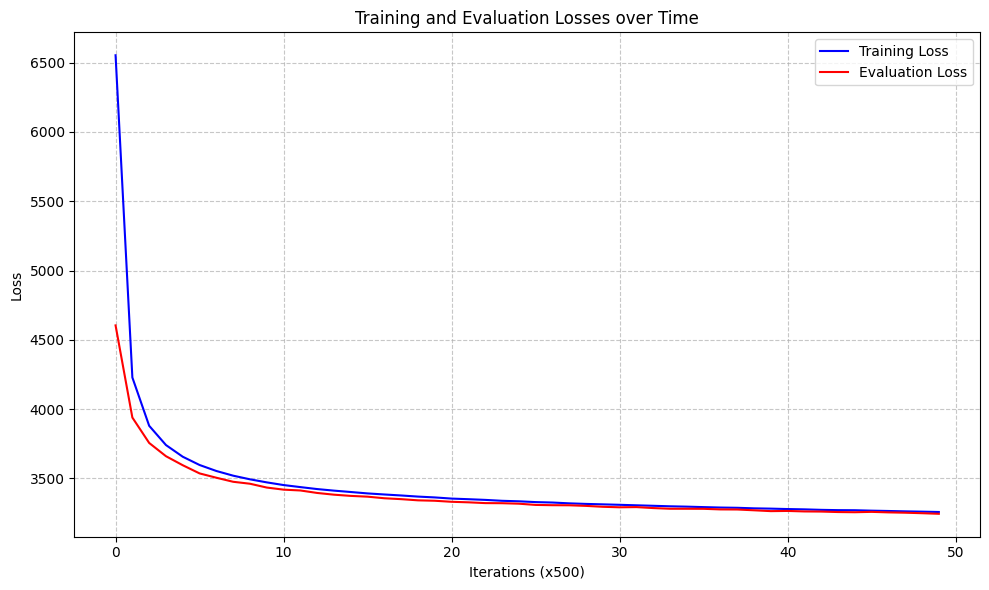

In [50]:
# Visualize your losses as your training progresses

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(eval_losses, label='Evaluation Loss', color='red')
plt.title('Training and Evaluation Losses over Time')
plt.xlabel('Iterations (x500)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Visualizations

In [54]:
import torch
import matplotlib.pyplot as plt

def get_digit_samples(digit, num_examples, data_loader):

    digit_samples = []

    for images, labels in data_loader:

        match = labels == digit
        digit_samples.append(images[match])
        if len(torch.cat(digit_samples)) >= num_examples:
            break

    digit_samples = torch.cat(digit_samples)[:num_examples]
    return digit_samples

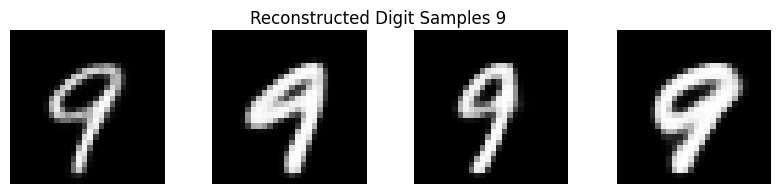

In [55]:
def visualize_generations(model, digit, num_examples, data_loader):

    # TODO: Implement the visualize_generations function
    # You will first encode the digit images into their latent space encodings
    # Then you will sample from the latent space and decode the samples to get the reconstructed images
    # You will then plot the reconstructed images
    # Use the plot_image function to plot the images

    # model.eval()

    digit_samples = get_digit_samples(digit, num_examples, data_loader)

    digit_samples = digit_samples.to(DEVICE)

    # Encode the digit images into their latent space encodings

    with torch.no_grad():
        mu, logvar = model.encode(digit_samples)
        z = model.reparameterize(mu, logvar)
        reconstructions = model.decode(z)

    # Ploting the reconstructed images
    plt.figure(figsize=(10, 2))

    for i in range(num_examples):
        plt.subplot(1, num_examples, i+1)
        plt.imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Reconstructed Digit Samples {digit}')
    plt.show()


digit = 9
num_examples = 4
model =  model.eval()
visualize_generations(model, digit, num_examples, train_loader)


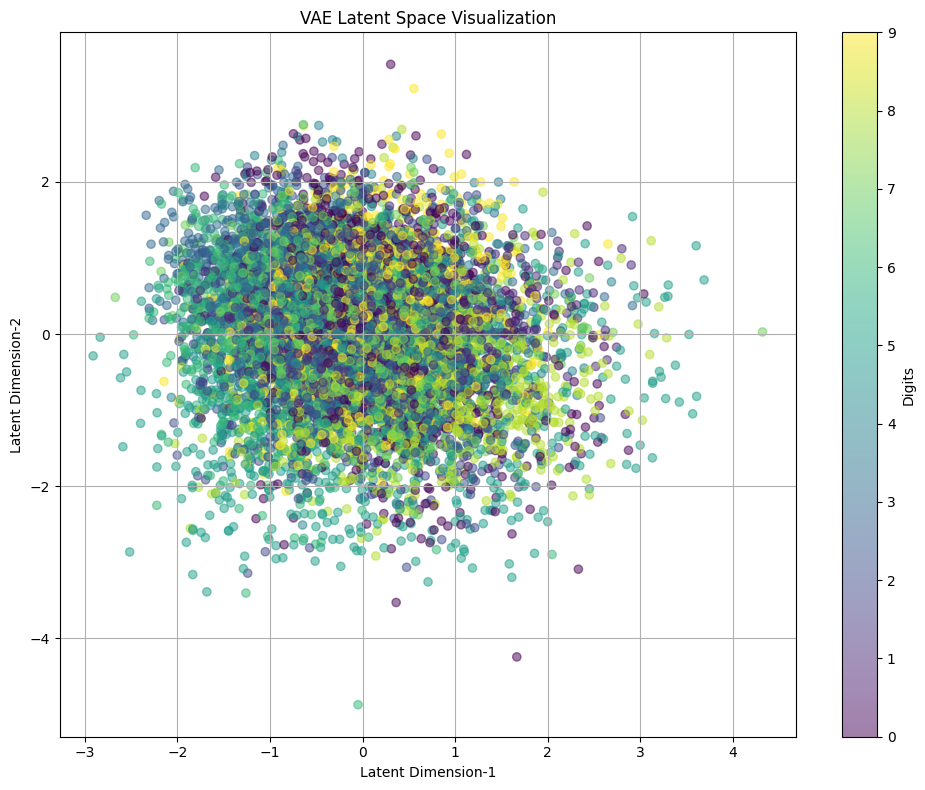

In [58]:
def visualize_latens(dataloader, model):
    # TODO: Implement the visualize_latens function
    # Set your model's latent space to 2 and train the model
    # Encode all samples from MNIST test loader to the latent space
    # Plot them using scatter plot to show how your model has been able differentiate between them

    #model.eval()

    latents = []
    labels = []

    with torch.no_grad():

        for data, target in dataloader:

            data = data.to(DEVICE)
            mu, logvar = model.encode(data)

            latents.append(mu.cpu().numpy())
            labels.append(target.cpu().numpy())

    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Scatter ploting of the latent space
    plt.figure(figsize=(10, 8))

    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, label='Digits')
    plt.title('VAE Latent Space Visualization')
    plt.xlabel('Latent Dimension-1')
    plt.ylabel('Latent Dimension-2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

model = model.eval()
visualize_latens(test_loader, model)



